In [1]:
"""
VML Image Sorting Inference Script
---------------------------------

Purpose
=======
Use a trained image-classification model to sort a directory of *unsorted* images
into class-named folders, while sending low-confidence / high-entropy predictions
into a *review* folder with a JSON manifest for human triage.

Highlights
==========
- Framework: PyTorch + Hugging Face Transformers (AutoModelForImageClassification)
- Optional face alignment using facenet_pytorch.MTCNN (toggle via --align)
- Temperature scaling (load from file, flag, or default 1.0)
- Test-Time Augmentation (TTA) averaging (--tta N)
- Batched, streaming inference with DataLoader (no huge RAM spikes)
- Confidence & entropy thresholds + minority-class override
- CSV of predictions, JSON review manifest, plain-text log
- Robust error handling and resumable outputs

Examples
========
# Typical run (auto device, alignment on, TTA=5)
python vml_infer_sort.py \
  --model /path/to/model_dir_or_ckpt \
  --images /path/to/images \
  --out /path/to/sorted_out \
  --review /path/to/review \
  --align --tta 5 --batch-size 32

# Custom thresholds and explicit temperature
python vml_infer_sort.py \
  --model ./runs/V34_export \
  --images ./unsorted \
  --out ./sorted \
  --review ./review \
  --base-threshold 0.35 \
  --entropy-threshold 1.9 \
  --minority-classes disgust fear sadness \
  --minority-threshold 0.38 \
  --temperature 1.25

# Load temperature from file within model dir (e.g., temperature.txt)
python vml_infer_sort.py --model ./runs/V34_export --images ./unsorted --out ./sorted --review ./review --align --temp-file temperature.txt

"""

'\nVML Image Sorting Inference Script\n---------------------------------\n\nPurpose\n=======\nUse a trained image-classification model to sort a directory of *unsorted* images\ninto class-named folders, while sending low-confidence / high-entropy predictions\ninto a *review* folder with a JSON manifest for human triage.\n\nHighlights\n==========\n- Framework: PyTorch + Hugging Face Transformers (AutoModelForImageClassification)\n- Optional face alignment using facenet_pytorch.MTCNN (toggle via --align)\n- Temperature scaling (load from file, flag, or default 1.0)\n- Test-Time Augmentation (TTA) averaging (--tta N)\n- Batched, streaming inference with DataLoader (no huge RAM spikes)\n- Confidence & entropy thresholds + minority-class override\n- CSV of predictions, JSON review manifest, plain-text log\n- Robust error handling and resumable outputs\n\nExamples\n========\n# Typical run (auto device, alignment on, TTA=5)\npython vml_infer_sort.py   --model /path/to/model_dir_or_ckpt   --im

In [2]:
# ------------------------------
# Imports
# ------------------------------
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple
from collections import Counter
import json, csv, math, shutil

import torch
import torch.nn.functional as F
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm

try:
    from facenet_pytorch import MTCNN
except Exception:
    MTCNN = None

from torchvision import transforms as T
from transformers import AutoModelForImageClassification, AutoImageProcessor, ViTForImageClassification

In [3]:
# ------------------------------
# Utilities
# ------------------------------
def is_image(p: Path) -> bool:
    return p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

def safe_mkdir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

def auto_device(prefer_mps: bool = True) -> torch.device:
    if prefer_mps and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

@dataclass
class Thresholds:
    base_conf: float = 0.35
    entropy: float = 1.9
    # V34 rule: be stricter for these
    minority_classes: Tuple[str, ...] = ("sadness", "speech_action")
    minority_conf: float = 0.90
    def conf_for(self, label: str) -> float:
        return self.minority_conf if label in self.minority_classes else self.base_conf

def load_temperature(model_dir: Path,
                     explicit_temp: Optional[float] = None,
                     temp_file: Optional[str] = None) -> float:
    """explicit > temp_file > stage1_calibration.json (model dir or parent) > txt files > 1.0"""
    if explicit_temp is not None:
        return float(explicit_temp)

    if temp_file:
        c = model_dir / temp_file
        if c.exists():
            try:
                if c.suffix.lower() == ".json":
                    data = json.loads(c.read_text())
                    for k in ("temperature","temp","T"):
                        if k in data and isinstance(data[k], (int,float)):
                            return float(data[k])
                else:
                    return float(c.read_text().strip())
            except Exception:
                pass

    for base in (model_dir, model_dir.parent):
        calib = base / "stage1_calibration.json"
        if calib.exists():
            try:
                data = json.loads(calib.read_text())
                for k in ("temperature","temp","T"):
                    if k in data and isinstance(data[k], (int,float)):
                        return float(data[k])
            except Exception:
                pass

    for name in ("temperature.txt","temp.txt"):
        cand = model_dir / name
        if cand.exists():
            try:
                return float(cand.read_text().strip())
            except Exception:
                pass

    return 1.0

def _detect_model_dir(p: Path) -> Path:
    """Return a dir containing config.json; otherwise search common subfolders."""
    if (p / "config.json").exists():
        return p
    for name in ("emotion_classifier_model","stage_2_emotion_model","model","checkpoint","hf_export"):
        cand = p / name
        if (cand / "config.json").exists():
            return cand
    for child in p.iterdir() if p.exists() and p.is_dir() else []:
        if child.is_dir() and (child / "config.json").exists():
            return child
    return p

In [4]:
# ------------------------------
# Dataset (streaming paths)
# ------------------------------
  
class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths: List[Path], align: bool, image_size: int = 224):
        self.image_paths = image_paths
        self.align = align
        self.image_size = image_size
        self._augment = T.Compose([T.RandomHorizontalFlip(), T.ColorJitter(0.2,0.2,0.2)])
        self.mtcnn = None
        if self.align:
            if MTCNN is None:
                raise RuntimeError("--align requested, but facenet_pytorch is not installed.")
            self.mtcnn = MTCNN(image_size=image_size, post_process=True)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx: int):
        path = self.image_paths[idx]
        try:
            img = Image.open(path).convert("RGB")
            if self.mtcnn is not None:
                aligned = self.mtcnn(img)
                if aligned is not None:
                    img = T.ToPILImage()(aligned)
            img = self._augment(img)  # light aug; processor will handle core transforms
            return path, img
        except UnidentifiedImageError as e:
            return path, e
        except Exception as e:
            return path, e

In [5]:
# ------------------------------
# Model Wrapper
# ------------------------------
@dataclass
class ModelBundle:
    model: torch.nn.Module
    processor: any
    id2label: dict
    label2id: dict
    device: torch.device
    temperature: float = 1.0

def load_model_bundle(model_path: Path,
                      device: torch.device,
                      explicit_temp: Optional[float] = None,
                      temp_file: Optional[str] = None) -> ModelBundle:
    model_dir = _detect_model_dir(model_path)
    model = AutoModelForImageClassification.from_pretrained(str(model_dir))
    processor = AutoImageProcessor.from_pretrained(str(model_dir))
    model.to(device).eval()

    id2label = getattr(model.config, "id2label", None) or {i: str(i) for i in range(model.config.num_labels)}
    label2id = {v: k for k, v in id2label.items()}

    # --- S2 temperature logic ---
    # Default: S2 has no calibration in your export -> 1.0 unless explicitly set
    temperature = 1.0 if explicit_temp is None else float(explicit_temp)

    # If a specific temp_file is provided, prefer it (json or txt) INSIDE the S2 model dir
    if explicit_temp is None and temp_file:
        tf = model_dir / temp_file
        if tf.exists():
            try:
                if tf.suffix.lower() == ".json":
                    data = json.loads(tf.read_text())
                    for k in ("temperature", "temp", "T"):
                        v = data.get(k)
                        if isinstance(v, (int, float)):
                            temperature = float(v)
                            break
                else:
                    temperature = float(tf.read_text().strip())
            except Exception:
                pass

    # Optional: stage2_calibration.json inside S2 dir
    if explicit_temp is None and temp_file is None:
        s2_cal = model_dir / "stage2_calibration.json"
        if s2_cal.exists():
            try:
                data = json.loads(s2_cal.read_text())
                for k in ("temperature", "temp", "T"):
                    v = data.get(k)
                    if isinstance(v, (int, float)):
                        temperature = float(v)
                        break
            except Exception:
                pass

    return ModelBundle(model=model,
                       processor=processor,
                       id2label=id2label,
                       label2id=label2id,
                       device=device,
                       temperature=temperature)

In [6]:
# ------------------------------
# Inference Core
# ------------------------------
@torch.inference_mode()
def predict_batch(bundle: ModelBundle, pil_images: List[Image.Image]):
    inputs = bundle.processor(images=pil_images, return_tensors="pt")
    inputs = {k: v.to(bundle.device) for k, v in inputs.items()}
    logits = bundle.model(**inputs).logits
    probs = F.softmax(logits / bundle.temperature, dim=-1)
    entropy = -(probs * probs.clamp_min(1e-8).log()).sum(dim=-1)
    return probs, entropy

def tta_average(bundle: ModelBundle, images: List[Image.Image], tta: int):
    if tta <= 1:
        return predict_batch(bundle, images)
    probs_list, ent_list = [], []
    for _ in range(tta):
        p, e = predict_batch(bundle, images)
        probs_list.append(p)
        ent_list.append(e)
    return torch.stack(probs_list).mean(0), torch.stack(ent_list).mean(0)

In [7]:
# ------------------------------
# Stage 1 (relevance) loader + predictor
# ------------------------------

def load_stage1_bundle(model_root: str, device: torch.device):
    """
    Finds '<root>/relevance_filter_model', loads the ViT classifier and a processor.
    Also loads calibration T and tau from stage1_calibration.json (root or S1 dir).
    """
    root = Path(model_root)
    s1_dir = root / "relevance_filter_model"
    if not (s1_dir / "config.json").exists():
        raise FileNotFoundError(f"Stage 1 export not found at: {s1_dir}")

    # Processor: use the HF processor saved with S1 to match its training
    proc = AutoImageProcessor.from_pretrained(str(s1_dir))
    s1 = ViTForImageClassification.from_pretrained(str(s1_dir)).to(device).eval()

    # Load calibration
    T_s1, tau = 1.0, 0.5
    for c in (root / "stage1_calibration.json", s1_dir / "stage1_calibration.json"):
        if c.exists():
            try:
                data = json.loads(c.read_text())
                T_s1 = float(data.get("T", T_s1))
                tau  = float(data.get("tau", tau))
                break
            except Exception:
                pass

    # id2label inspection
    id2label_s1 = getattr(s1.config, "id2label", {0:"0",1:"1"})
    label2id_s1 = {v:k for k,v in id2label_s1.items()}

    # Find numeric id for "relevant" (fallback: assume the higher id is relevant)
    relevant_ids = [k for k,v in id2label_s1.items() if str(v).lower() == "relevant"]
    relevant_id = relevant_ids[0] if relevant_ids else max(id2label_s1.keys())

    return {"model": s1, "processor": proc, "id2label": id2label_s1,
            "label2id": label2id_s1, "relevant_id": relevant_id,
            "T": T_s1, "tau": tau, "device": device}

@torch.inference_mode()
def stage1_relevant_prob(s1_bundle, pil_images):
    """Return P(relevant) for each image using temperature scaling T."""
    proc = s1_bundle["processor"]
    model = s1_bundle["model"]
    device = s1_bundle["device"]
    T    = s1_bundle["T"]
    r_id = s1_bundle["relevant_id"]

    inputs = proc(images=pil_images, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    logits = model(**inputs).logits / T
    probs  = torch.softmax(logits, dim=-1)  # [B,2]
    return probs[:, r_id]

In [8]:
# ------------------------------
# Stage 2 Sorting Pipeline
# ------------------------------
def sort_images_notebook(
    model_dir: str,
    images_dir: str,
    out_dir: str,
    review_dir: str,
    *,
    batch_size: int = 32,
    num_workers: int = 0,
    tta: int = 5,
    image_size: int = 224,
    thresholds: Thresholds = Thresholds(),
    align: bool = False,            # IMPORTANT: match your training (no alignment)
    temperature: Optional[float] = None,
    temp_file: Optional[str] = None,
    prefer_mps: bool = True,
    pred_csv: Optional[str] = None,
    use_stage1_gate: bool = True,   # NEW: turn S1 gate on/off
):
    device = auto_device(prefer_mps=prefer_mps)
    print(f"💻 device: {device}")

    # Stage 2 bundle (emotions)
    bundle = load_model_bundle(Path(model_dir), device, explicit_temp=temperature, temp_file=temp_file)
    print(f"📦 model labels: {sorted(set(bundle.id2label.values()))}")
    print(f"🌡️ S2 temperature (loaded): {bundle.temperature}")

    # Stage 1 (relevance) gate load
    s1 = None
    if use_stage1_gate:
        try:
            s1 = load_stage1_bundle(model_dir, device)
            print(f"🧭 S1 gate: T={s1['T']:.3f}  τ={s1['tau']:.3f}  relevant_id={s1['relevant_id']}")
        except Exception as e:
            print(f"⚠️ Could not load Stage 1 gate: {e}. Continuing without S1.")
            use_stage1_gate = False

    # Collect images
    images = [p for p in Path(images_dir).rglob("*") if is_image(p)]
    images.sort()
    if not images:
        print(f"⚠️ no images under {images_dir}")
        return {"processed": 0, "mean_conf": None, "mean_entropy": None, "counts": {}}

    out_dir = Path(out_dir); review_dir = Path(review_dir)
    safe_mkdir(out_dir); safe_mkdir(review_dir)

    dataset = ImagePathDataset(images, align=align, image_size=image_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,
                                         num_workers=num_workers, collate_fn=lambda b: b)

    counts = Counter(); review_manifest = []; log_lines = []
    csv_path = Path(pred_csv) if pred_csv else (review_dir / "predictions.csv")
    with csv_path.open("w", newline="") as cf:
        writer = csv.writer(cf)
        writer.writerow(["file","pred_label","pred_conf","entropy","top3","s1_prob"])

        total_conf = 0.0; total_entropy = 0.0; n = 0
        pbar = tqdm(total=len(images), desc="🔍 sorting (images)")
        for batch in loader:
            paths, imgs = [], []
            for (path, item) in batch:
                if isinstance(item, Exception):
                    review_manifest.append({"file": str(path), "top3": [], "conf": None, "entropy": None, "reason": "unreadable"})
                    pbar.update(1); continue
                paths.append(path); imgs.append(item)

            if not imgs:
                continue

            # --- S1 gate ---
            s1_probs = None
            if use_stage1_gate:
                s1_probs = stage1_relevant_prob(s1, imgs).detach().cpu()  # [B]
                pass_mask = (s1_probs >= s1["tau"])
                pass_indices = torch.nonzero(pass_mask, as_tuple=False).flatten().tolist()
                review_indices = torch.nonzero(~pass_mask, as_tuple=False).flatten().tolist()
            else:
                pass_indices = list(range(len(imgs)))
                review_indices = []

            # Route S1-failed images straight to review
            for idx in review_indices:
                path = paths[idx]
                dest = review_dir / "irrelevant_or_lowS1"
                safe_mkdir(dest)
                try: shutil.copy2(path, dest / path.name)
                except Exception: pass

                s1p = float(s1_probs[idx].item()) if use_stage1_gate else None
                review_manifest.append({"file": str(path), "top3": [], "conf": None, "entropy": None,
                                        "reason": "stage1_gate", "s1_prob": s1p})
                log_lines.append(f"{path} | S1(prob_relevant)={s1p}\n")
                counts["stage1_filtered"] += 1
                n += 1; pbar.update(1)

            # --- S2 on passers ---
            if pass_indices:
                imgs_s2 = [imgs[i] for i in pass_indices]
                probs, entropy = tta_average(bundle, imgs_s2, tta=tta)
                conf, pred_idx = probs.max(dim=-1)
                probs_cpu, ent_cpu = probs.detach().cpu(), entropy.detach().cpu()
                conf_cpu, pred_idx_cpu = conf.detach().cpu(), pred_idx.detach().cpu()

                for j, local_idx in enumerate(pass_indices):
                    path = paths[local_idx]
                    c = float(conf_cpu[j]); e = float(ent_cpu[j]); idx = int(pred_idx_cpu[j])
                    label = str(bundle.id2label.get(idx, str(idx)))

                    topk = torch.topk(probs_cpu[j], k=min(3, probs_cpu.size(1)))
                    top3 = [(str(bundle.id2label.get(int(i), str(int(i)))), float(p))
                            for p, i in zip(topk.values.tolist(), topk.indices.tolist())]

                    thr = thresholds.conf_for(label)
                    if (c < thr) or (e > thresholds.entropy):
                        reason = "thresholds"; final_label = "unknown"; dest = review_dir / "unknown"
                    else:
                        reason = "passed"; final_label = label; dest = out_dir / final_label

                    safe_mkdir(dest)
                    try: shutil.copy2(path, dest / path.name)
                    except Exception:
                        reason = "copy_failed"; dest = review_dir / "unknown"; safe_mkdir(dest)
                        try: shutil.copy(path, dest / path.name)
                        except Exception: pass

                    counts[final_label] += 1
                    s1p = float(s1_probs[local_idx].item()) if use_stage1_gate else None
                    log_lines.append(f"{path} | S1={s1p} | S2={label} | conf={c:.4f} | ent={e:.4f} | top3={[(lab, round(p,3)) for lab,p in top3]}\n")
                    writer.writerow([str(path), label, f"{c:.6f}", f"{e:.6f}", json.dumps(top3), s1p])

                    if reason != "passed":
                        review_manifest.append({"file": str(path), "top3": [(lab, round(p,4)) for lab,p in top3],
                                                "conf": round(c,6), "entropy": round(e,6),
                                                "reason": reason, "s1_prob": s1p})

                    total_conf += c; total_entropy += e; n += 1; pbar.update(1)

        pbar.close()

    (review_dir / "sorting_log.txt").write_text("".join(log_lines))
    with (review_dir / "review_manifest.json").open("w") as f:
        json.dump(review_manifest, f, indent=2)

    summary = {"processed": int(sum(counts.values())),
               "mean_conf": (total_conf / n) if n else None,
               "mean_entropy": (total_entropy / n) if n else None,
               "counts": dict(sorted(counts.items()))}
    print("\n✅ done.")
    if summary["processed"]:
        print(f"📊 mean_conf={summary['mean_conf']:.4f}  |  mean_entropy={summary['mean_entropy']:.4f}")
    else:
        print("⚠️ no samples processed")
    for k, v in summary["counts"].items():
        print(f"  {k:18s}: {v}")
    return summary

In [9]:
# ------------------------------
# Visualization Helper (optional post-run)
# ------------------------------
def visualize_review_grid(review_dir: str, max_images: int = 25):
    import matplotlib.pyplot as plt
    manifest_path = Path(review_dir) / "review_manifest.json"
    if not manifest_path.exists():
        print("no manifest found"); return
    manifest = json.loads(manifest_path.read_text())
    if not manifest:
        print("manifest empty"); return
    rows = cols = int(math.ceil(math.sqrt(min(len(manifest), max_images))))
    plt.figure(figsize=(cols*3, rows*3))
    for i, entry in enumerate(manifest[: rows*cols]):
        try:
            img = Image.open(entry["file"]).convert("RGB")
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(img)
            title = entry.get('top3', [['',0]])[0][0]
            ax.set_title(f"{title}\nconf={entry.get('conf')} ent={entry.get('entropy')}")
            ax.axis("off")
        except Exception:
            continue
    plt.tight_layout(); plt.show()

💻 device: mps
📦 model labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'neutral_speech', 'questioning', 'sadness', 'speech_action', 'surprise']
🌡️ S2 temperature (loaded): 1.0
🧭 S1 gate: T=3.184  τ=0.300  relevant_id=1


🔍 sorting (images):   0%|          | 0/5331 [00:00<?, ?it/s]


✅ done.
📊 mean_conf=0.5344  |  mean_entropy=0.6290
  anger             : 9
  contempt          : 97
  disgust           : 1
  fear              : 22
  happiness         : 512
  neutral           : 461
  neutral_speech    : 1276
  questioning       : 1429
  stage1_filtered   : 1432
  surprise          : 37
  unknown           : 55


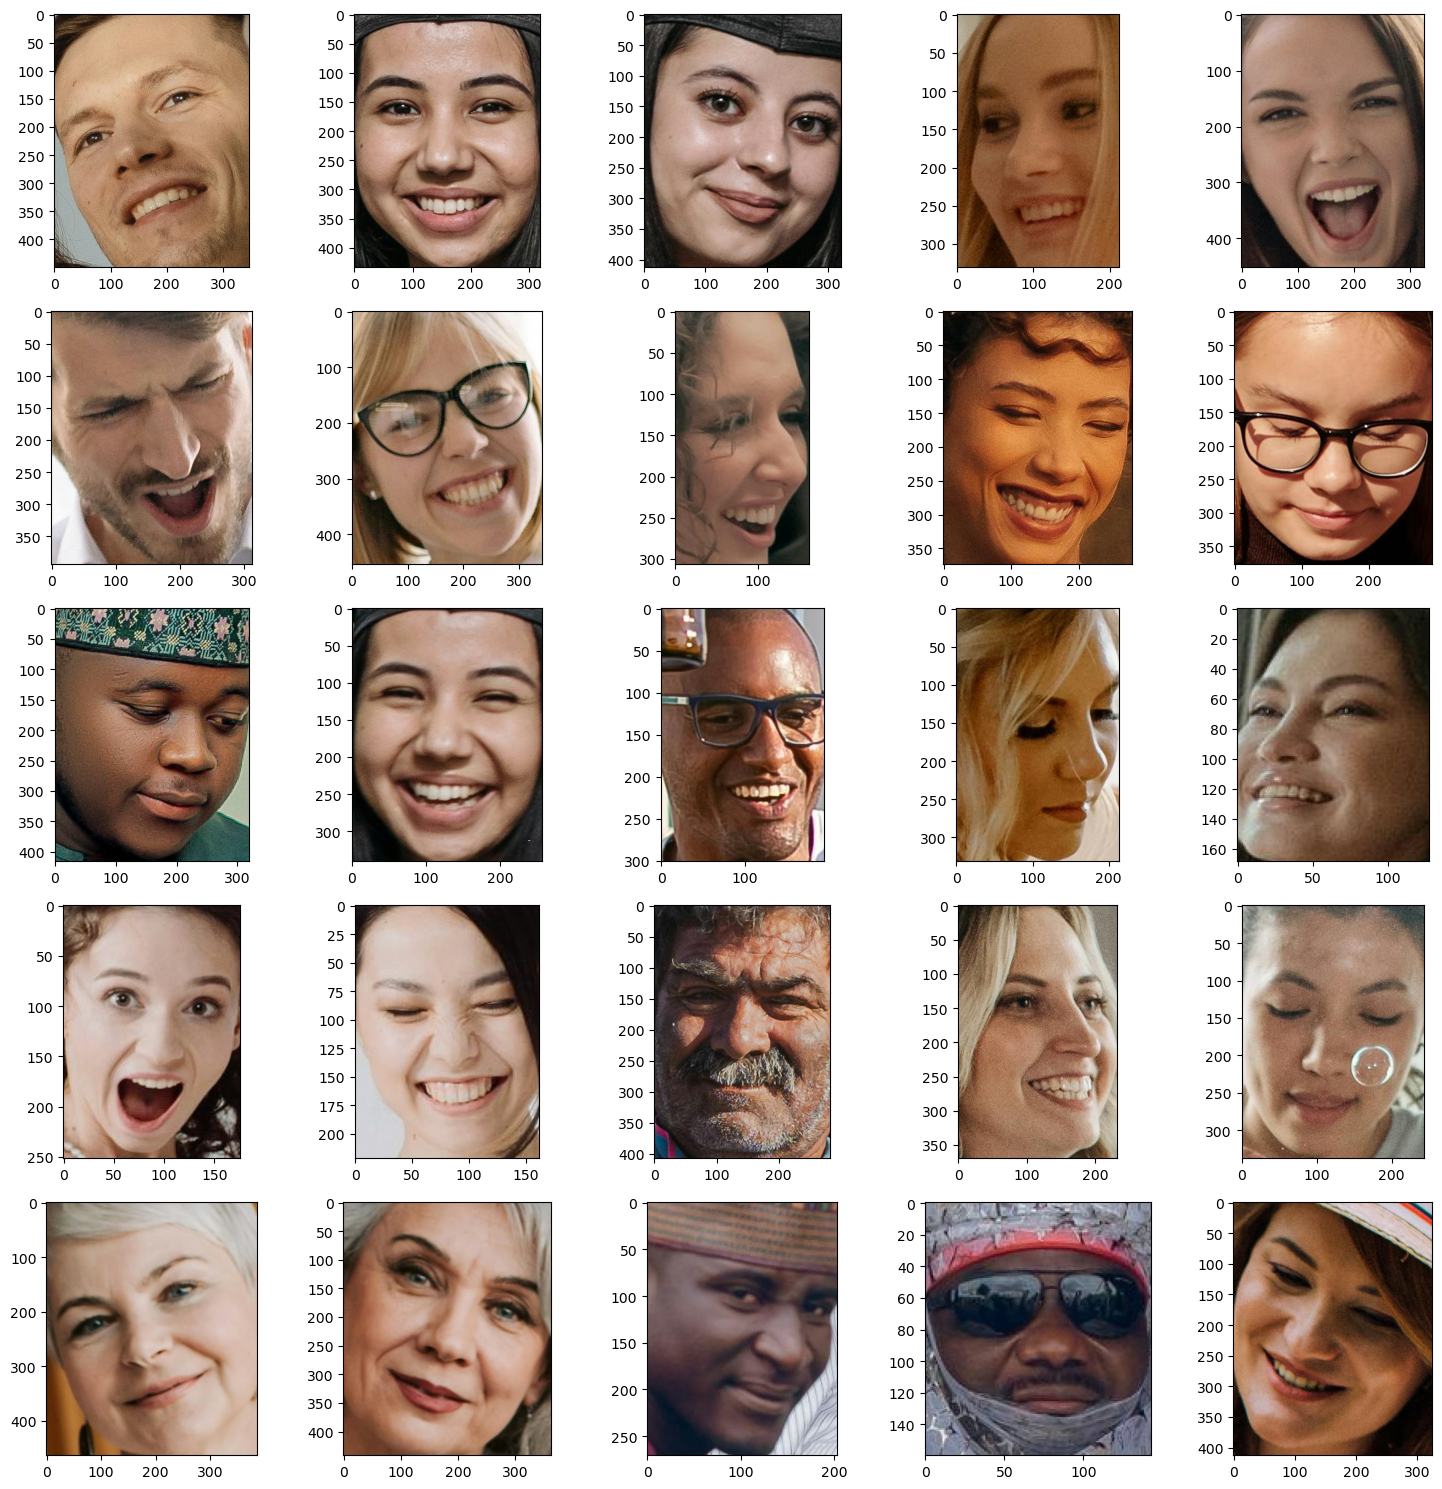

In [10]:
# ------------------------------
# Run Cell
# ------------------------------
MODEL_DIR  = "/Users/natalyagrokh/AI/ml_expressions/img_expressions/sup_training/V34_20251013_211825"
IMAGES_DIR = "/Users/natalyagrokh/AI/ml_expressions/img_datasets/pexels_dataset_archive/pexels_curated"
OUT_DIR    = "/Users/natalyagrokh/AI/ml_expressions/img_datasets/pexels_dataset_archive/sorted_out_nb"
REVIEW_DIR = "/Users/natalyagrokh/AI/ml_expressions/img_datasets/pexels_dataset_archive/review_out_nb"

summary = sort_images_notebook(
    model_dir=MODEL_DIR,
    images_dir=IMAGES_DIR,
    out_dir=OUT_DIR,
    review_dir=REVIEW_DIR,
    align=False, # match training
    tta=5,
    batch_size=32,
    use_stage1_gate=True, # turn on the two-stage flow
    temperature=1.0,  # <-- S2 T=1.0 since there is no stage2 calibration
)
summary

visualize_review_grid(REVIEW_DIR, max_images=25)